In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.optimize import curve_fit

In [2]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'ppt2latex',
 'ppt2latex2',
 'ppt2latexsubfig',
 'ppt2latexsubfig_smlegend',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [3]:
plt.style.use('ppt2latex')
plt.rcParams["font.family"] = "Times New Roman"

# Data Import

In [12]:
co2y = np.loadtxt('measurements/TCS_resp/CO2Y_point95W_step_minute_trend_october_18_2018.dat')     # CO2Y change by .95 W (Sensed by HWSY)
rhy = np.loadtxt('measurements/TCS_resp/ITMY_trend_10min_int_longer.dat')                          # RHY change by ? W (Sensed by HWSY)
carr_self = np.loadtxt('measurements/TCS_resp/1W_self_heating_defocus_doublepass.txt', skiprows=1) # Self heating model from COMSOL

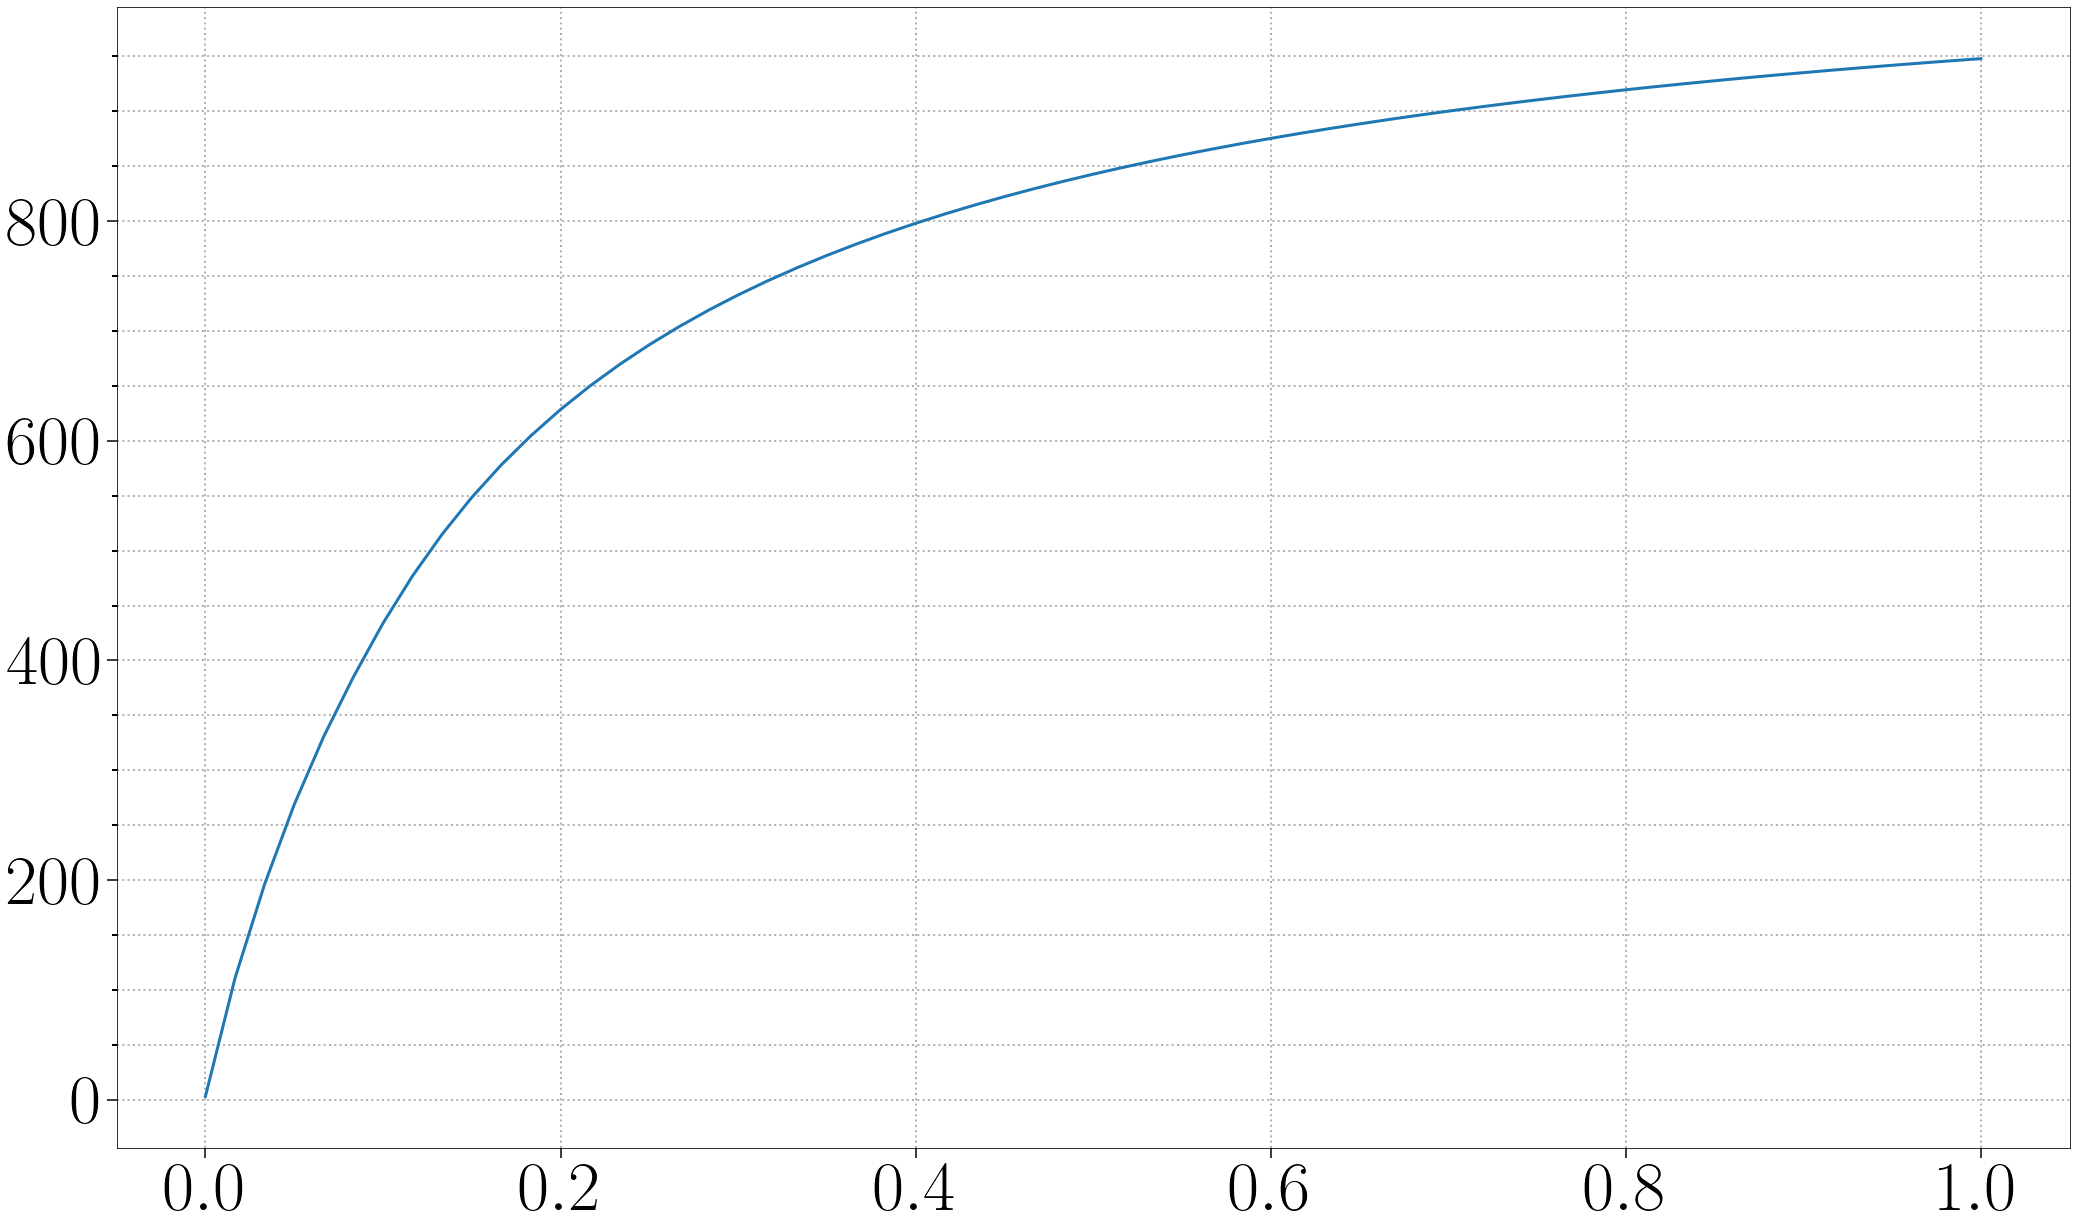

In [13]:
plt.plot(carr_self[:,0], carr_self[:,1])

# Data Pre-filter

Text(0, 0.5, 'Defocus [1/m]')

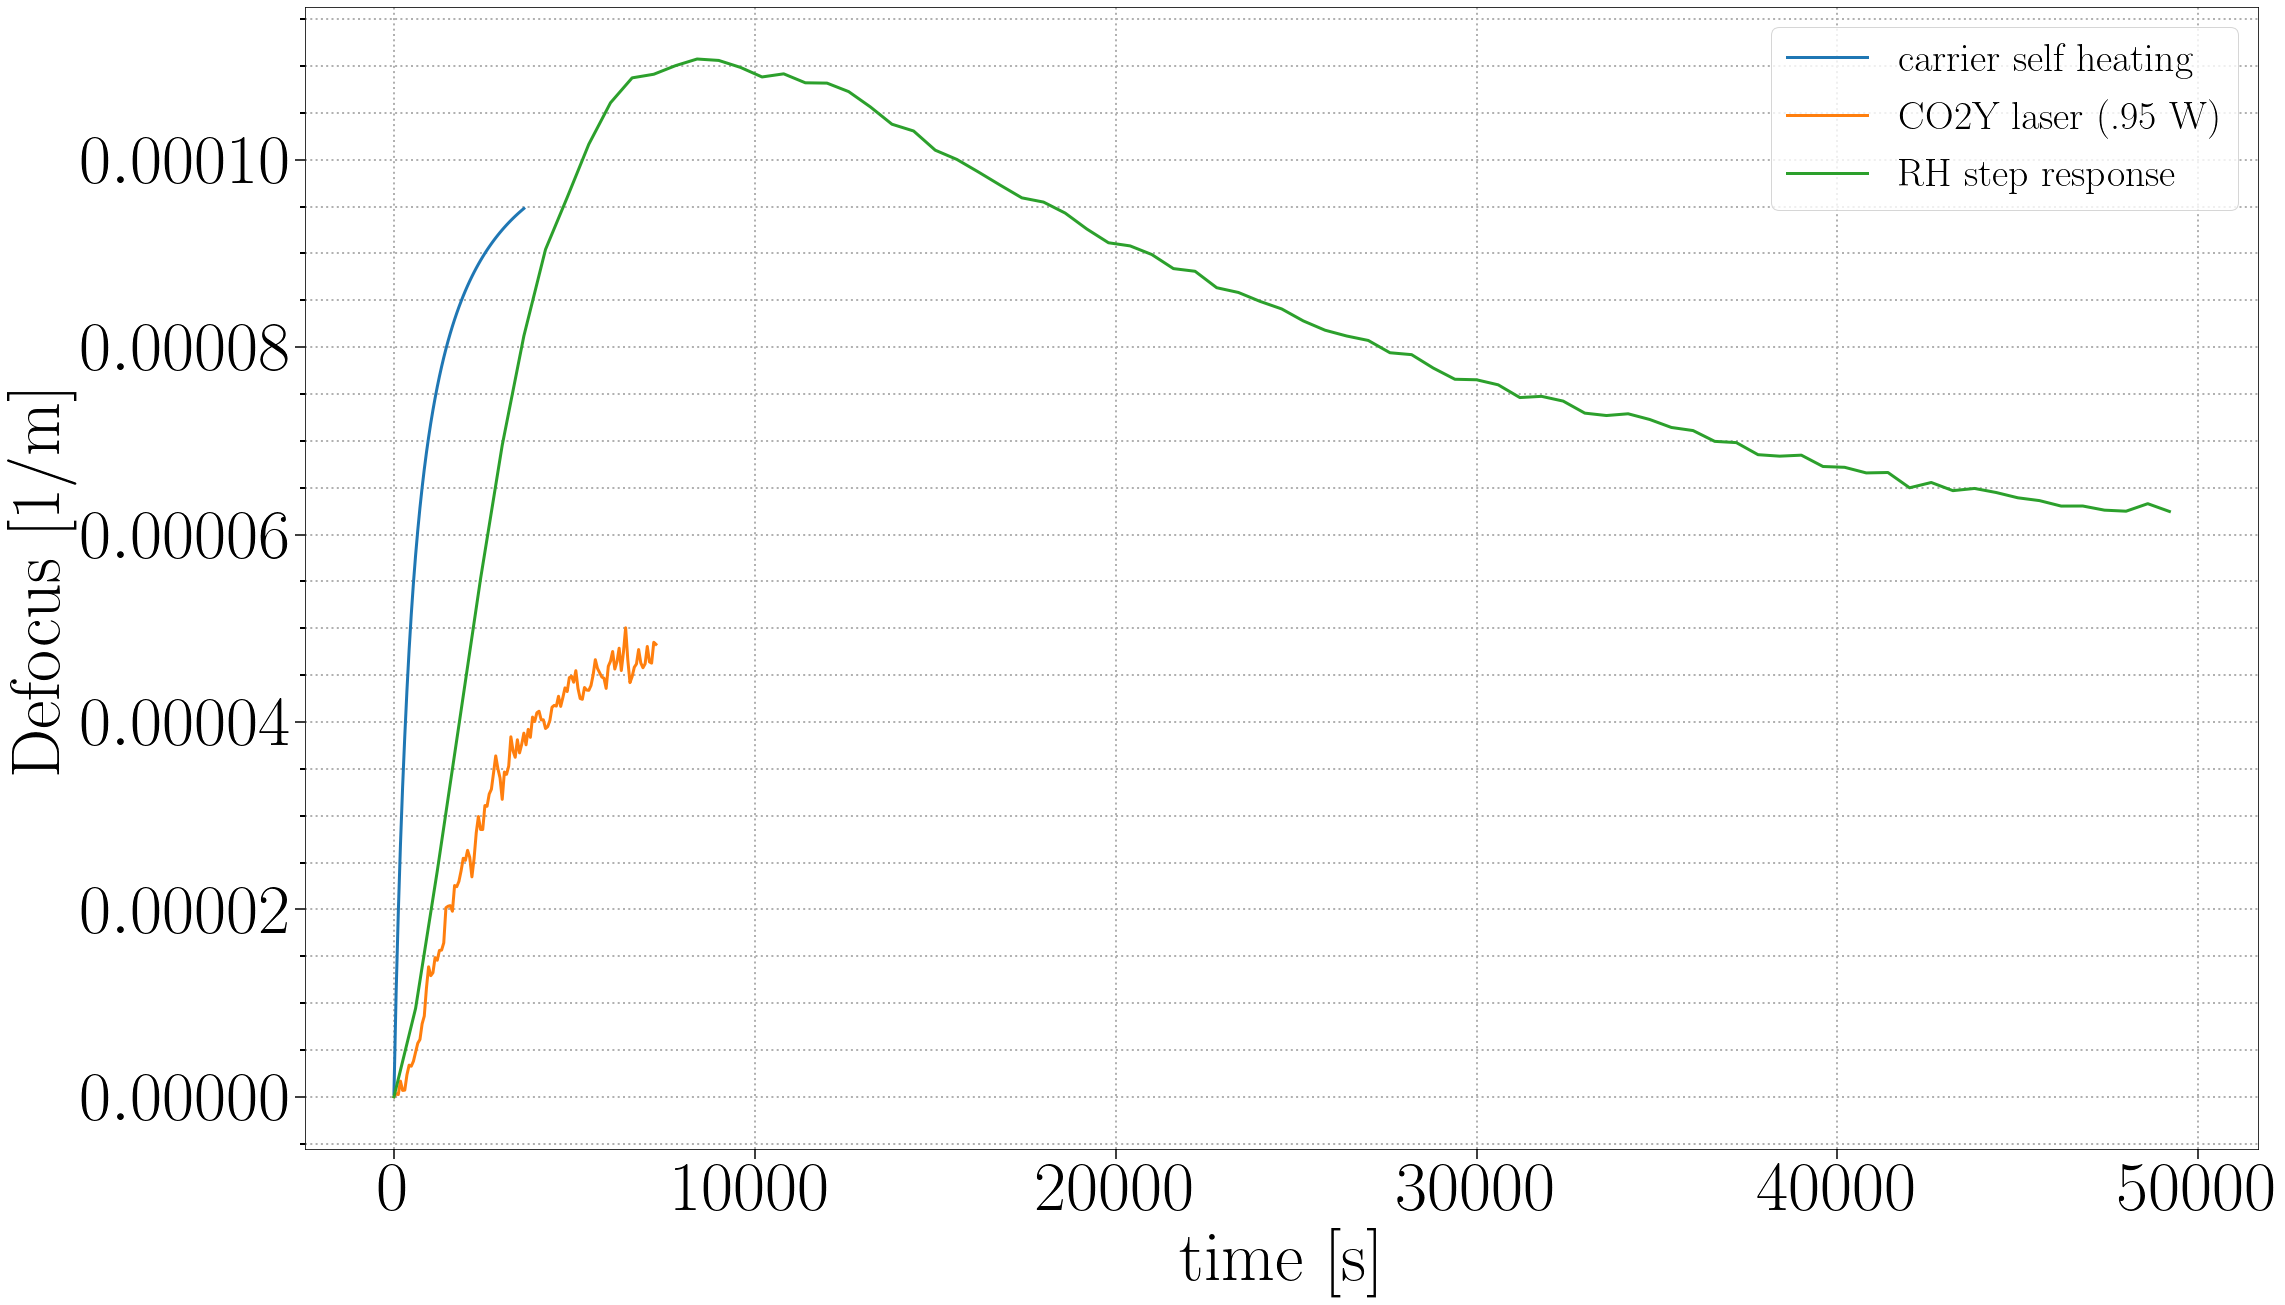

In [14]:
## COMSOL self heating
plt.plot(carr_self[:,0]*60*60, carr_self[:,1]*1e-7, label='carrier self heating')
## OCTOBER 18th CO2Y step response data
t = np.arange(0,len(co2y[:,0]),1)*60
co2y_ = co2y[:,1] + abs(min(co2y[:,1]))
plt.plot(t,co2y_, label='CO2Y laser (.95 W)')

## ITMY RH response data
trhy = np.arange(0,len(rhy[:,1][2:]))*600
plt.plot(trhy, rhy[:,1][2:]-min(rhy[:,1][2:]), label = 'RH step response')

plt.legend()
plt.xlabel('time [s]')
plt.ylabel('Defocus [1/m]')

In [15]:
b, a = signal.butter(4, 0.15)
b2, a2 = signal.butter(3, 0.0512)

In [16]:
b2, a2 = signal.butter(3, 0.0512)
co2y_smooth = signal.filtfilt(b2,a2,co2y[:,1])

In [17]:
y2 = signal.filtfilt(b,a,co2y[:,1])
rhy_smooth = signal.filtfilt(b,a,rhy[:,1][2:])

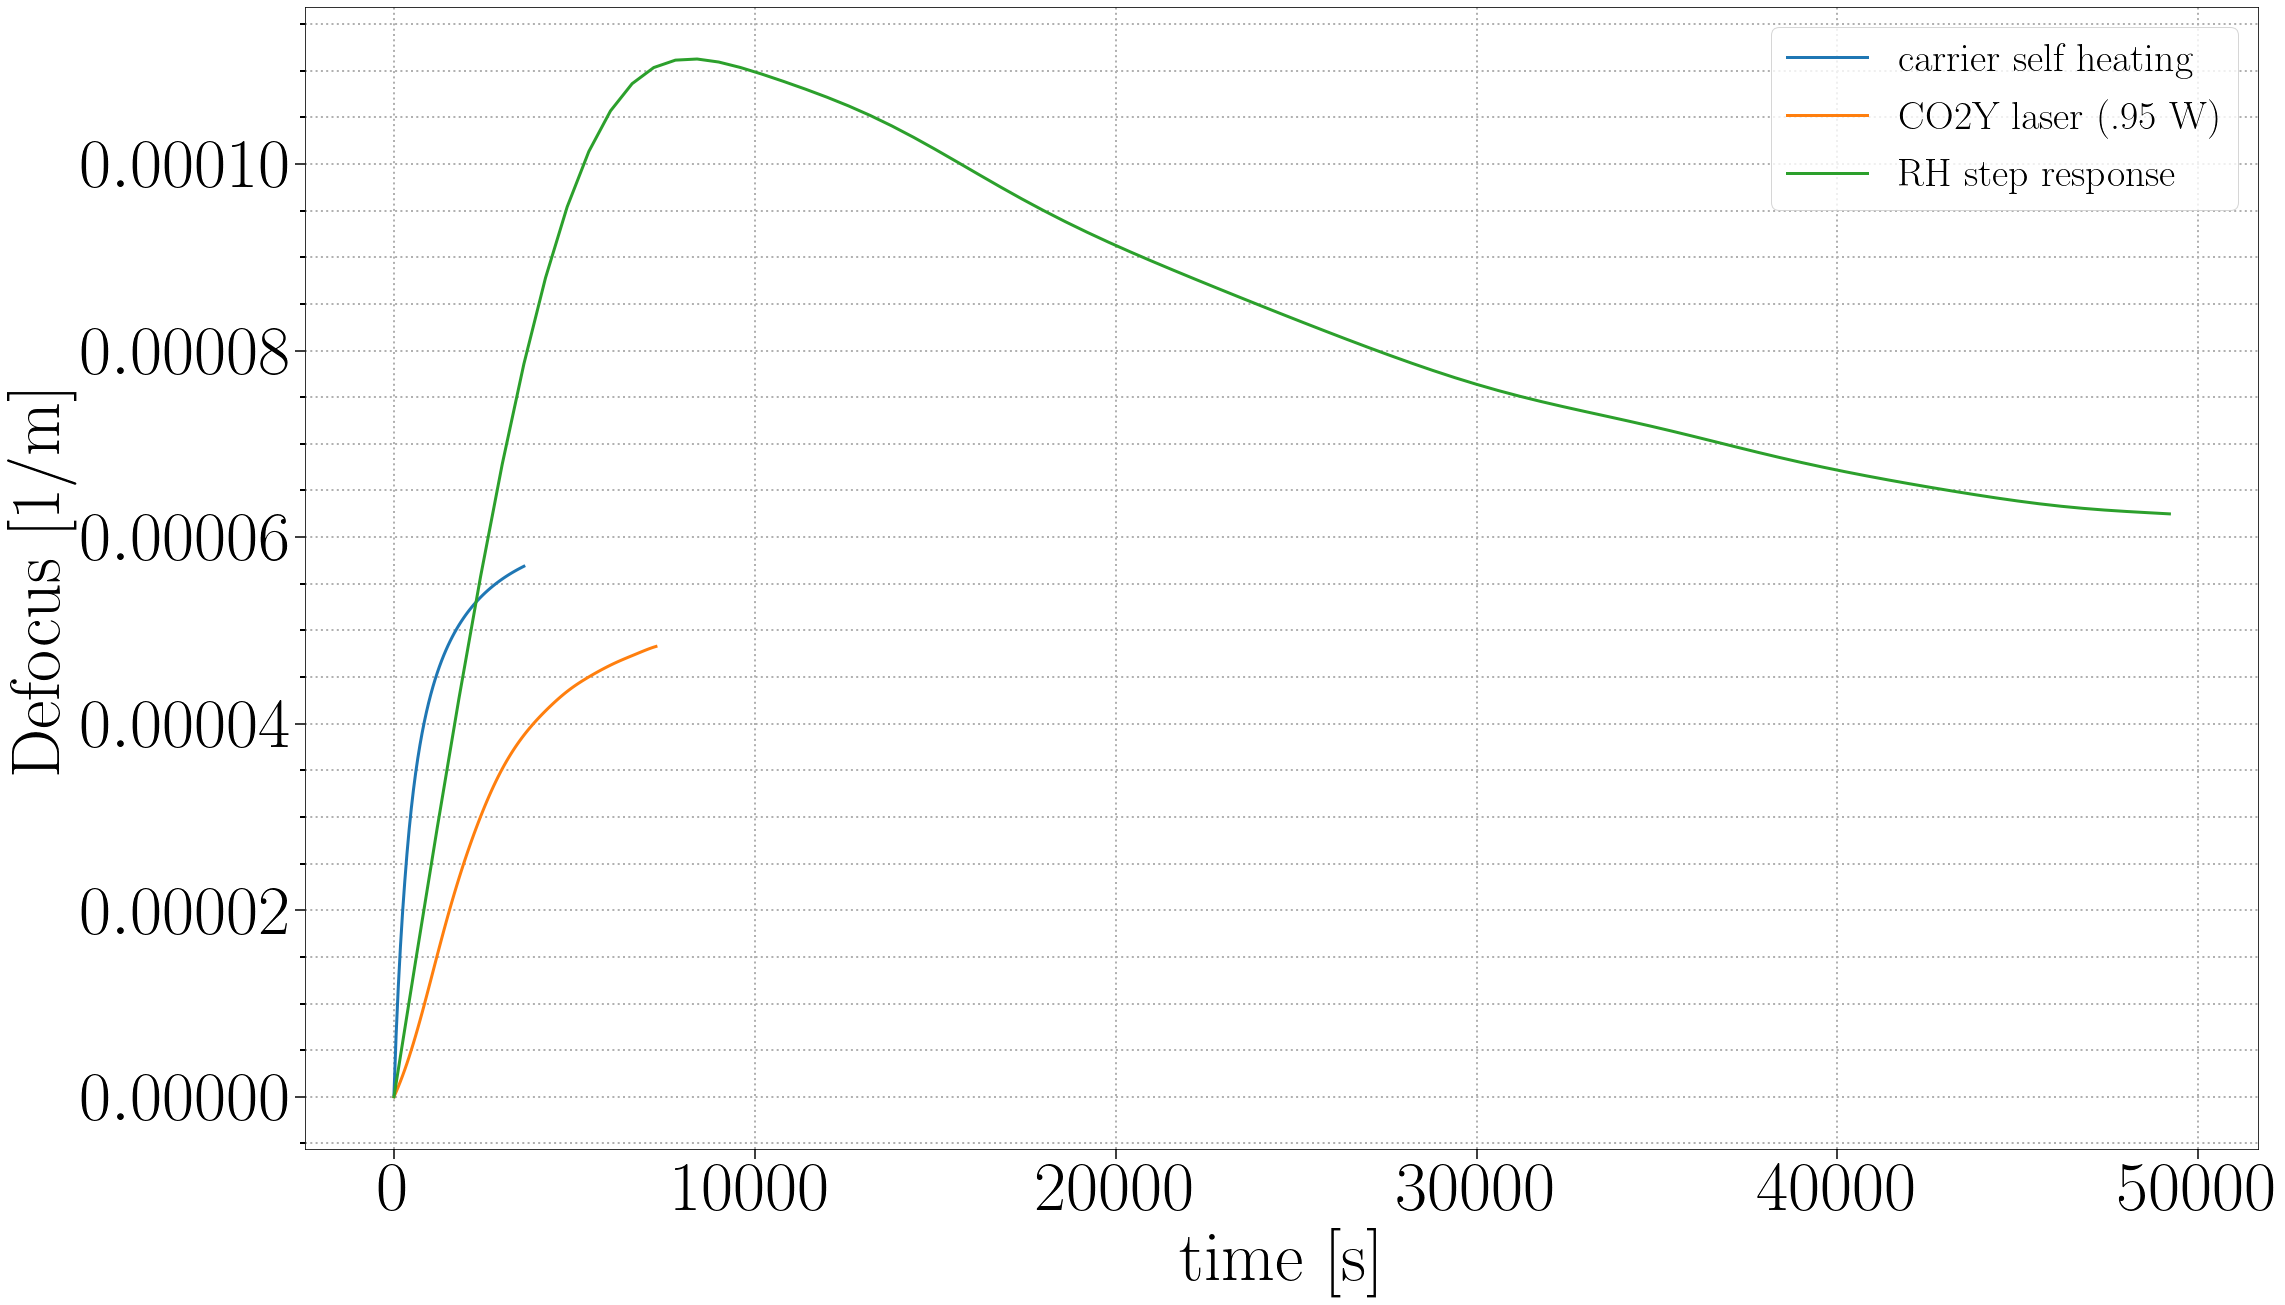

In [18]:
plt.plot(carr_self[:,0]*60*60, carr_self[:,1]*.6e-7, label='carrier self heating')
#plt.plot(t_rhy1,y_self_test_longer*.62e-4,label='fit',linewidth=4)

plt.plot(t,co2y_smooth + abs(min(co2y_smooth)), label='CO2Y laser (.95 W)')

plt.plot(np.arange(0,len(rhy[:,1][2:]))*600,rhy_smooth-min(rhy_smooth), label='RH step response')
#plt.plot(rhy[:,0], rhy[:,1])

plt.legend()
plt.xlabel('time [s]')
plt.ylabel('Defocus [1/m]')
plt.savefig('../figs/TCS/TCS_resp_butter_meas.pdf', dpi=300, bbox_inches='tight')

## Generate TCS filters
* Run through IRHF algorithm
    * Establish power step
    * Build zpk model
        * Divide by set power to set correct gain
        * Apply a Laplace transform to bring response into s-space
        * Multiply step response by zpk filter to match true response
    * Invert filter and apply stability filters
    * Compare to natural response and check for increased efficiency

In [19]:
P_CO2Y = .95     #[W] central heating
P_RH = 3.13      #[W] annular heating 
self_heating = 1 #[W] absorbed power

In [20]:
### RH (plant) filter

83


<Figure size 2520x1512 with 0 Axes>

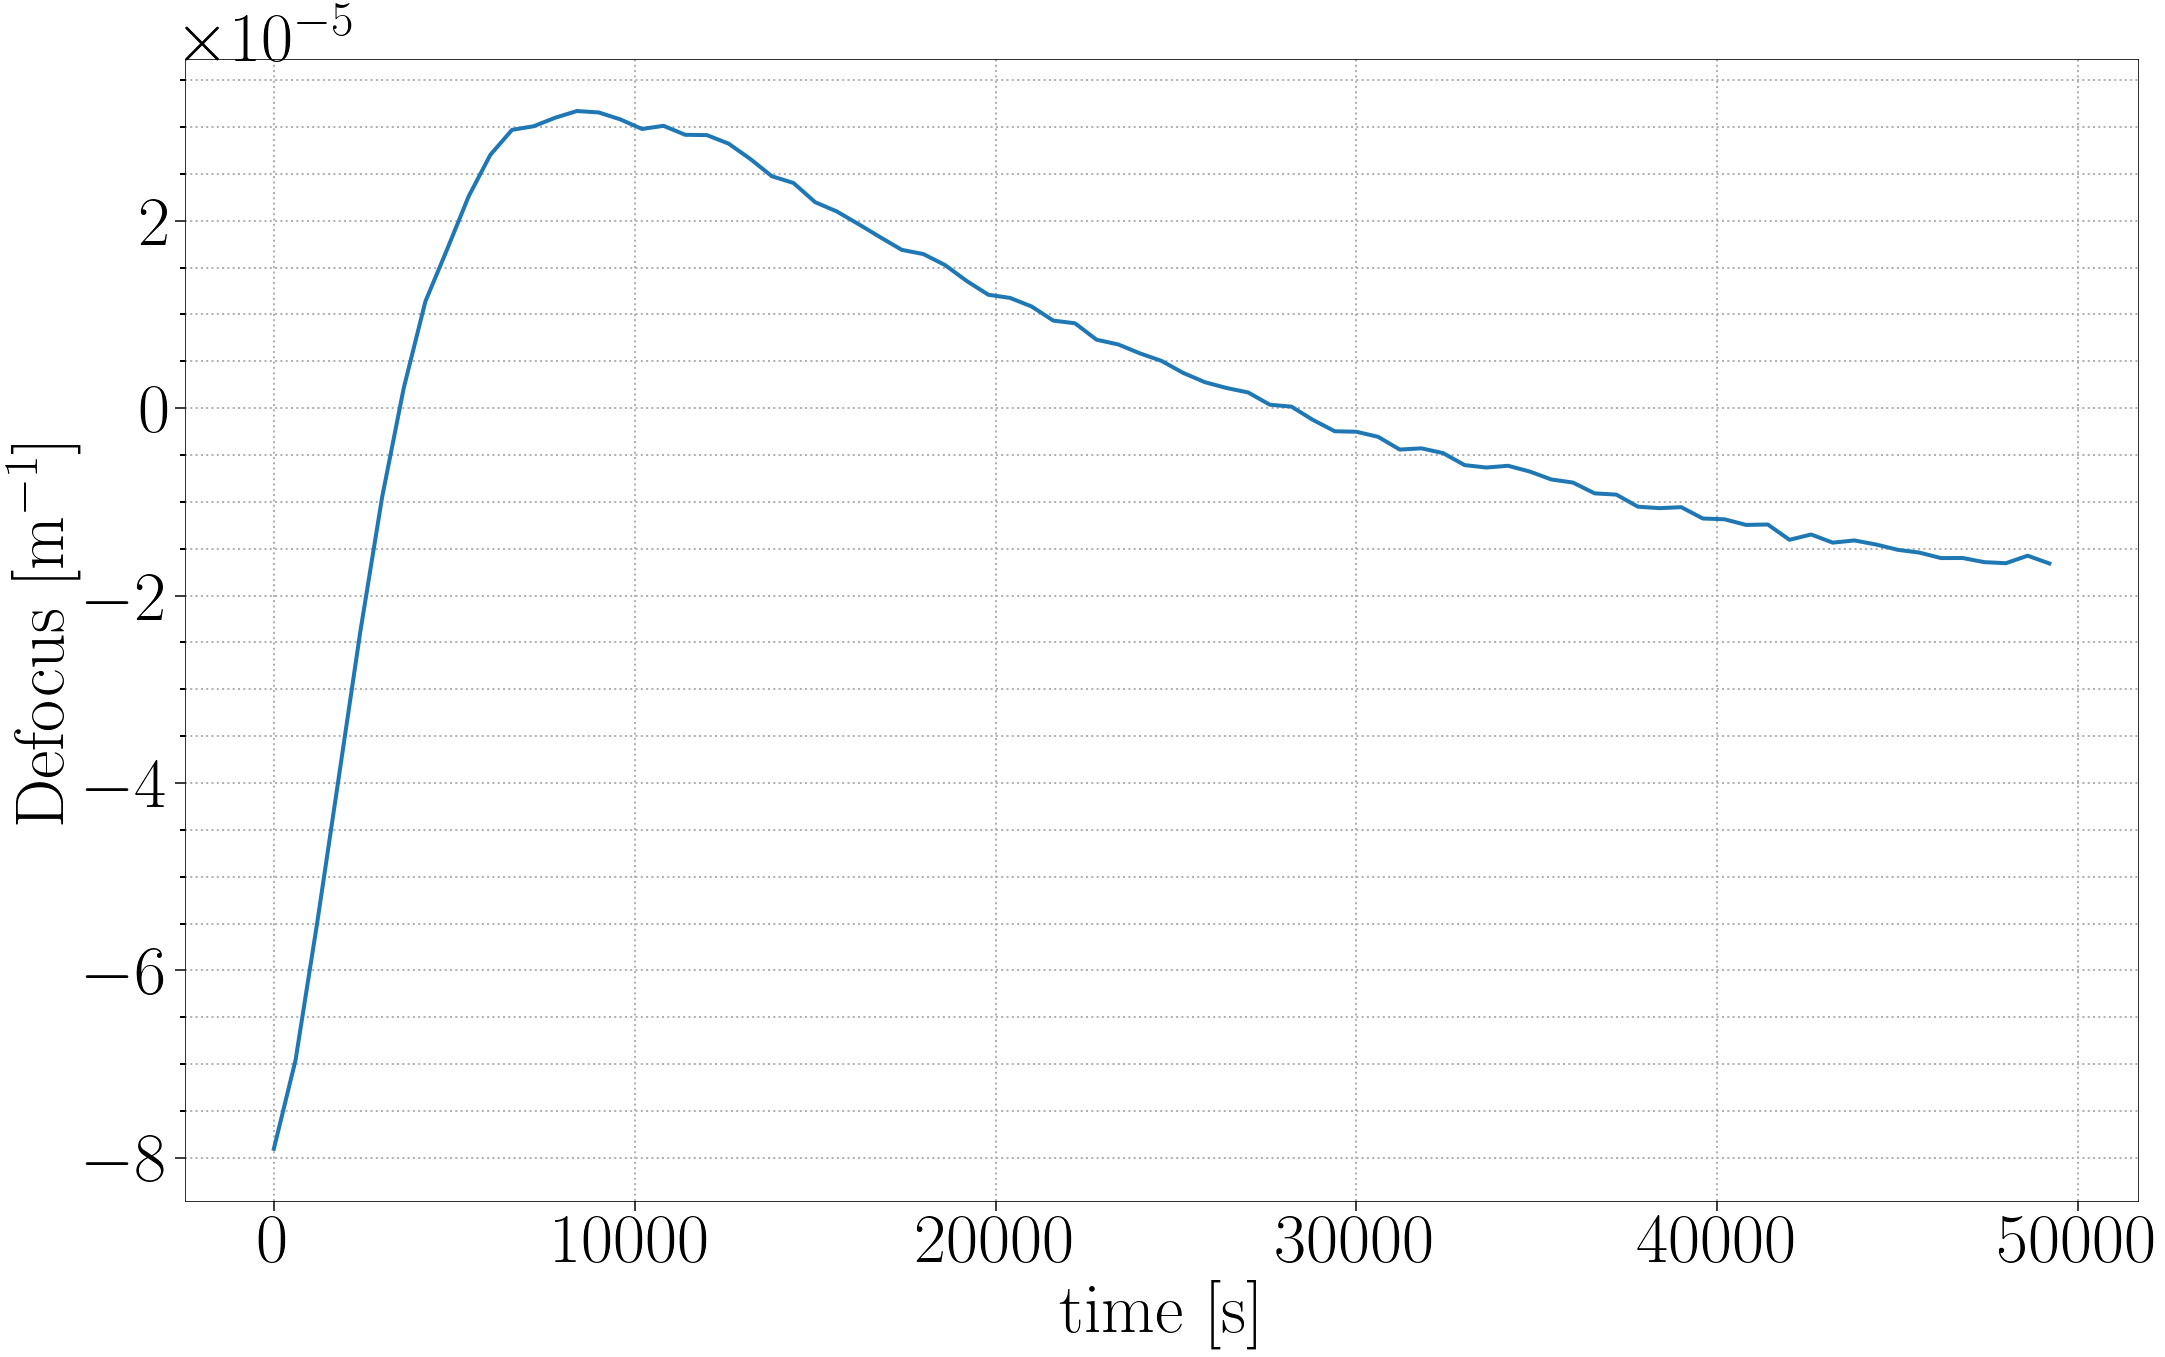

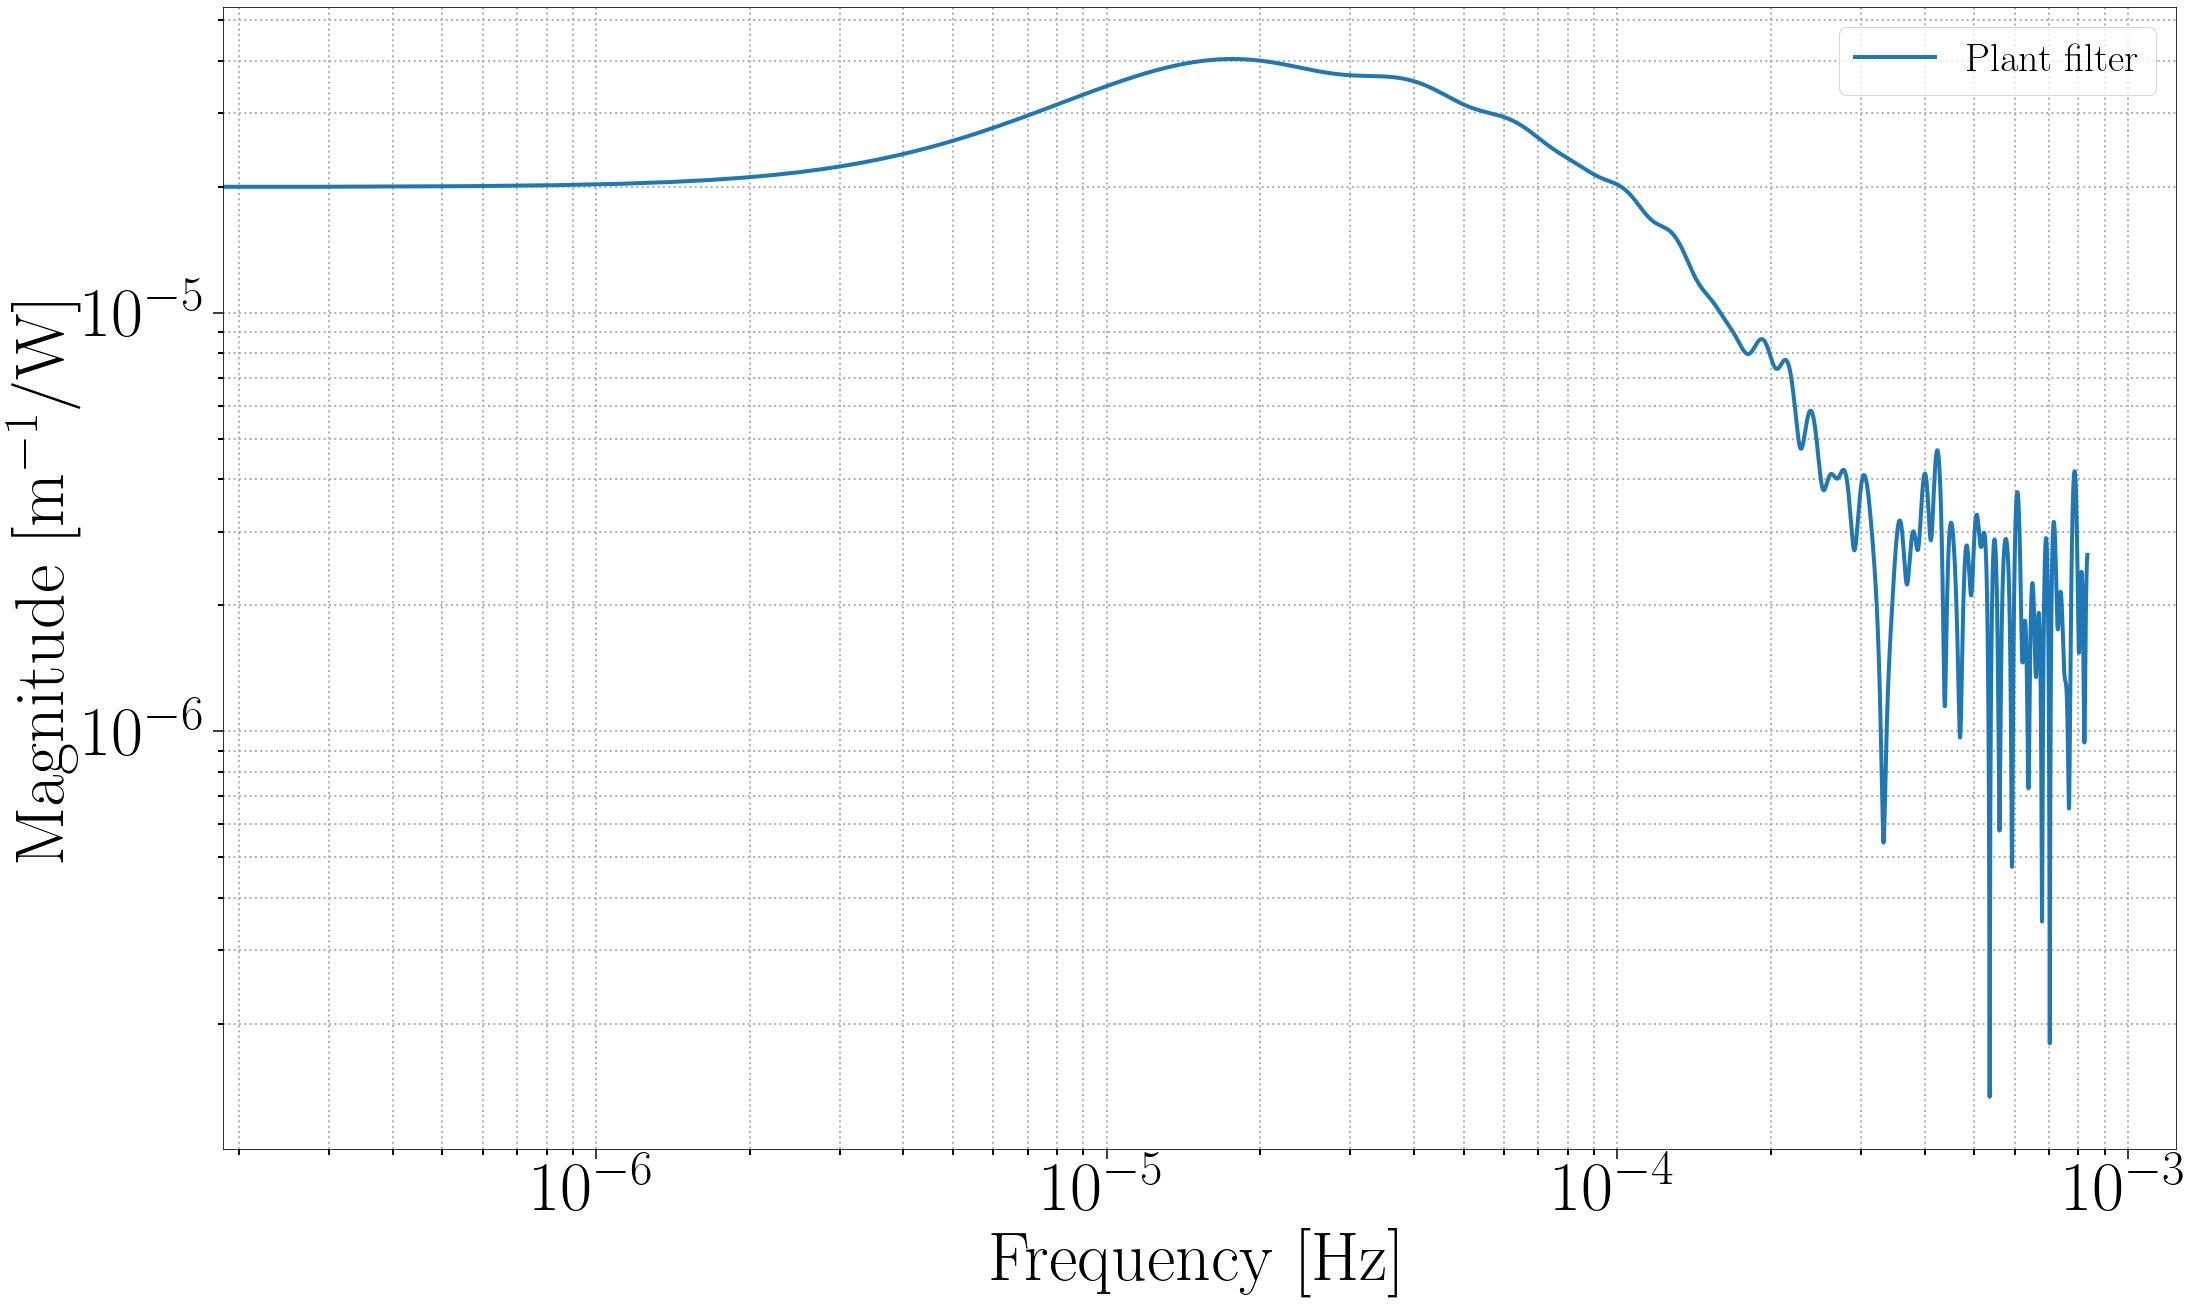

4.993706070287539e-06


In [21]:
normalize = 3.13
print(len(trhy))
rhy_datain = rhy[:,1][2:]
b, a = signal.butter(2, .2)
#data_new = signal.filtfilt(b,a,data_in)
plt.figure()
ir = (rhy_datain[1:] - rhy_datain[:-1])/normalize
fig1 = plt.figure()
plt.plot(trhy, rhy_datain, label='Step response',linewidth=4)
#plt.plot(t[:(len(t)-1)], ir, label= 'Impulse response')
plt.xlabel('time [s]')
plt.ylabel('Defocus [m$^{-1}$]')
#plt.legend(fontsize='medium')
plt.show()

Fs = 1/(trhy[2]-trhy[1])
#print(Fs)

[F,H]=signal.freqz(ir,1, worN=3000,whole=False) 
fig2 = plt.figure()
plt.loglog(F*Fs/(2*np.pi), abs(H), label='Plant filter',linewidth=4)
plt.ylabel('Magnitude [m$^{-1}$/W]')
plt.xlabel('Frequency [Hz]')
plt.legend()
plt.show()

print(max(ir))


/var/folders/7r/5_lt1_453rxbdqfqjyb0kx500000gn/T/ipykernel_27849/2814219194.py:20: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0,(F[-1]/(2*np.pi)*Fs)])


9.729529652779821e-12


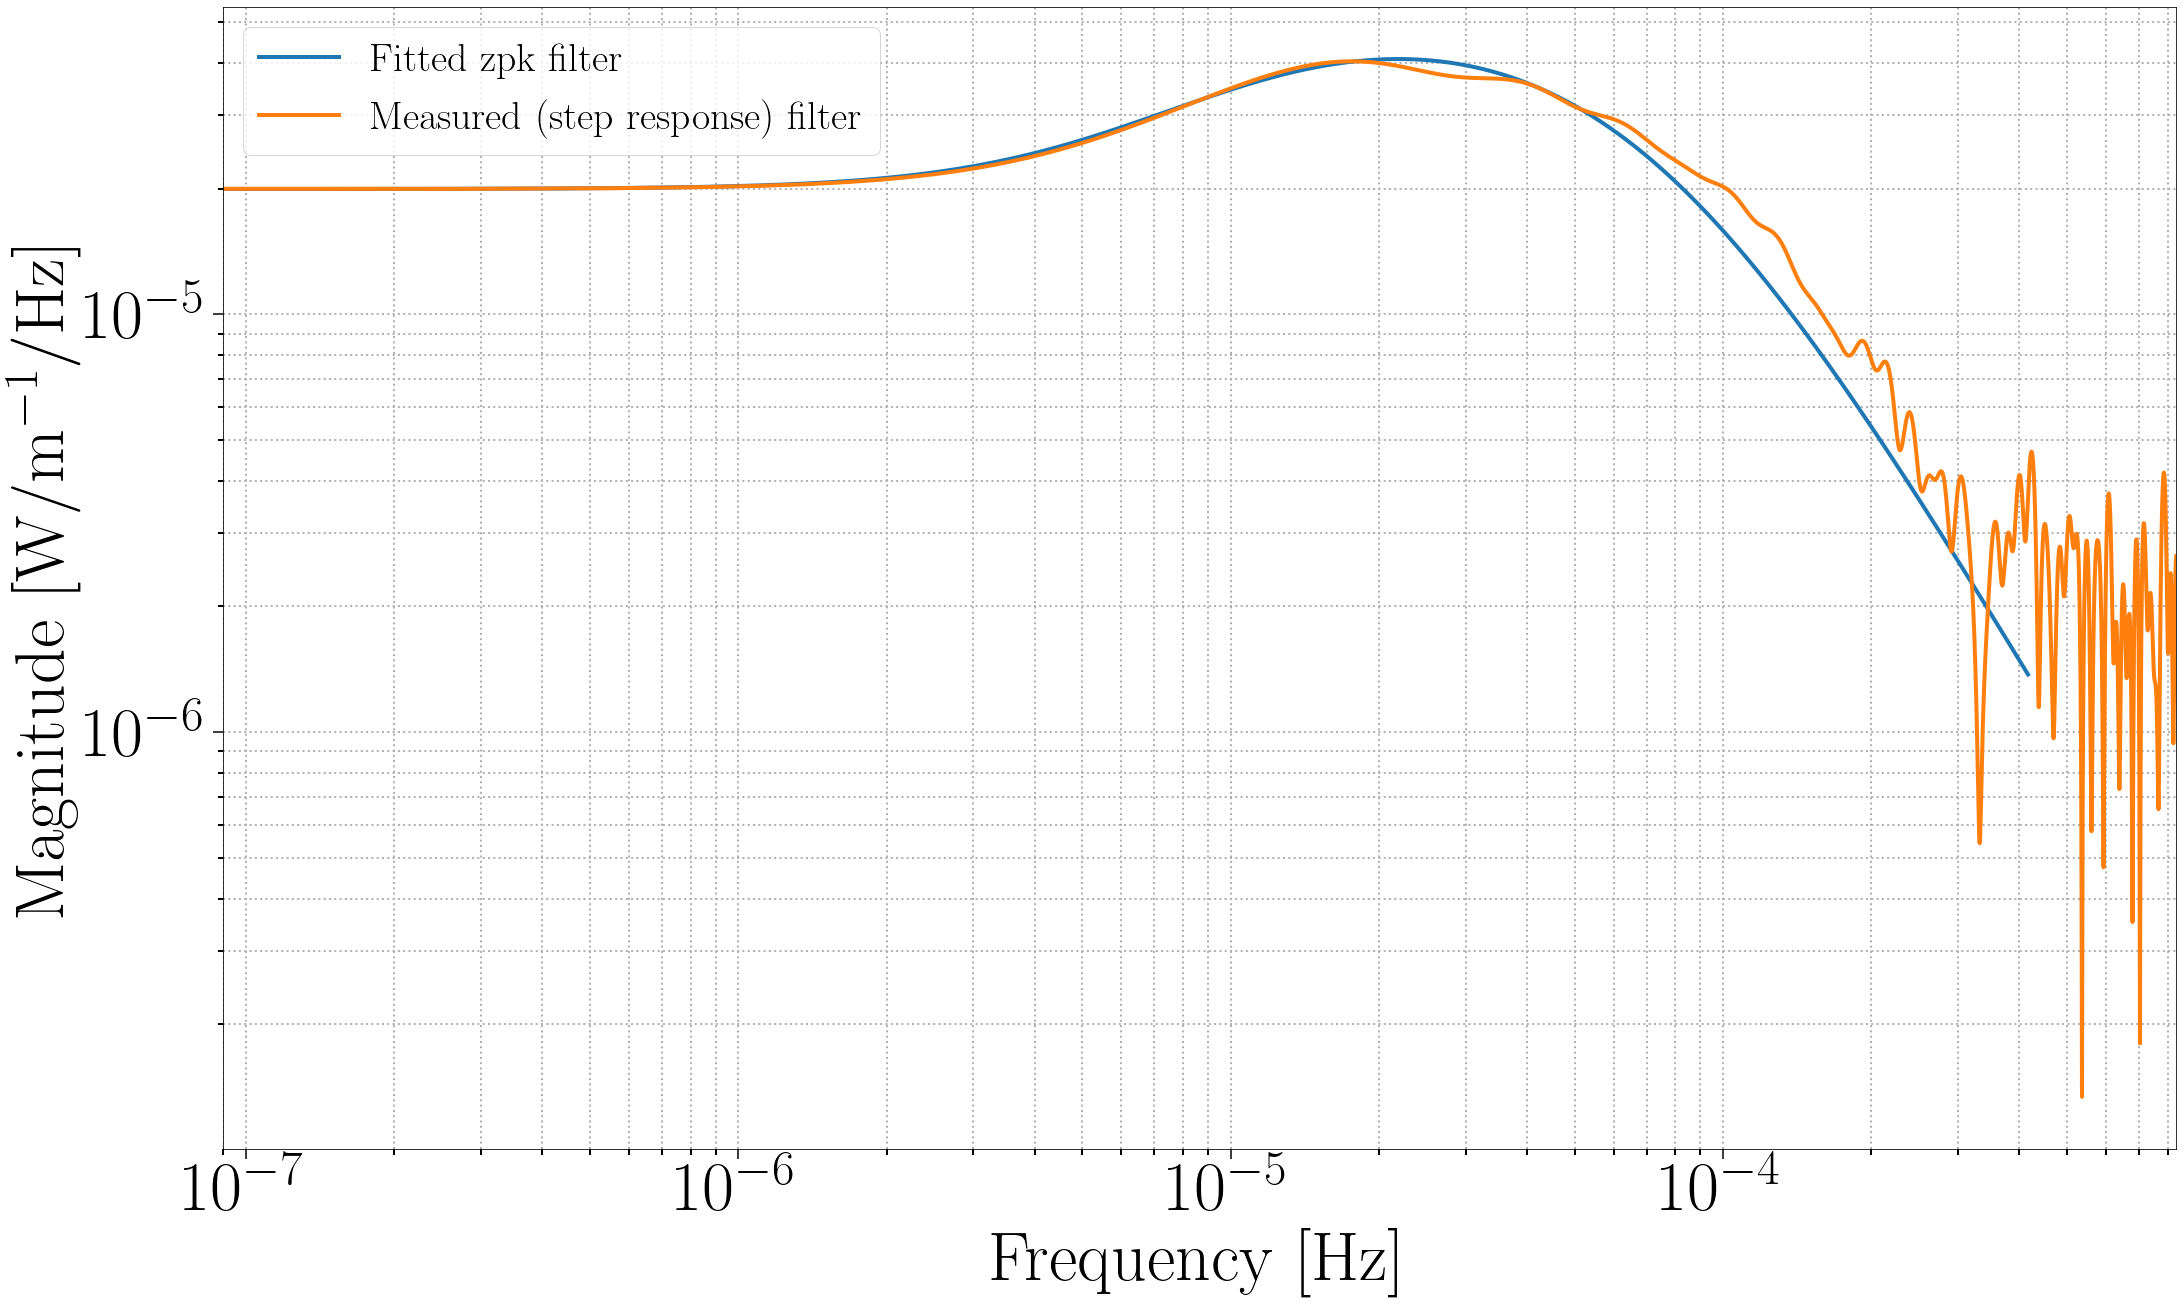

In [22]:
zeros = 5.0e-6
fit_zeros = -2.0*np.pi*5.0e-6
poles = np.array([1.3e-5, 5.0e-5 ,9.5e-5])
fit_poles = -2.0*np.pi*poles

k = 1 #This gain is not initally correct

s1 = signal.ZerosPolesGain(fit_zeros, fit_poles, k)
F_2, H_2 = signal.freqresp(s1, F*(Fs/2.0))

#[F_2,H_2] = signal.freqs(b_2, a_2)
k_new = abs(H[0])/abs(H_2[0])

plt.loglog(F_2/(2*np.pi), abs(H_2)*k_new, label='Fitted zpk filter',linewidth=4)
plt.loglog(F/(2*np.pi)*Fs, abs(H), label='Measured (step response) filter',linewidth=4)
plt.ylabel('Magnitude [W/m$^{-1}/\mathrm{Hz}$]')
plt.xlabel('Frequency [Hz]')
plt.legend()
#plt.title('RH plant filter (H(s))')
plt.xlim([0,(F[-1]/(2*np.pi)*Fs)])
print(k_new) #Spit out the new gain
##plt.grid(b=True,which='minor')
##plt.grid(b=True,which='major')
##plt.minorticks_on()

model_zpk = signal.ZerosPolesGain(fit_zeros, fit_poles,k_new)

In [72]:
[ _ ,y_RH_test, _] = signal.lsim(model_zpk, unit_step_testing1, trhy1)

### Self Heating Filter

In [73]:
t_com = carr_self[:,0]*3600
defocus = carr_self[:,1]/max(carr_self[:,1])
ir_com  = (defocus[1:] - defocus[:-1])
t_ir = t_com[:((len(t_com)-1))]

In [74]:
[F_ir,H_ir]=signal.freqz(ir_com, 1, worN=3000,whole=False) 
Fs_com =1/(t_com[1]-t_com[0])

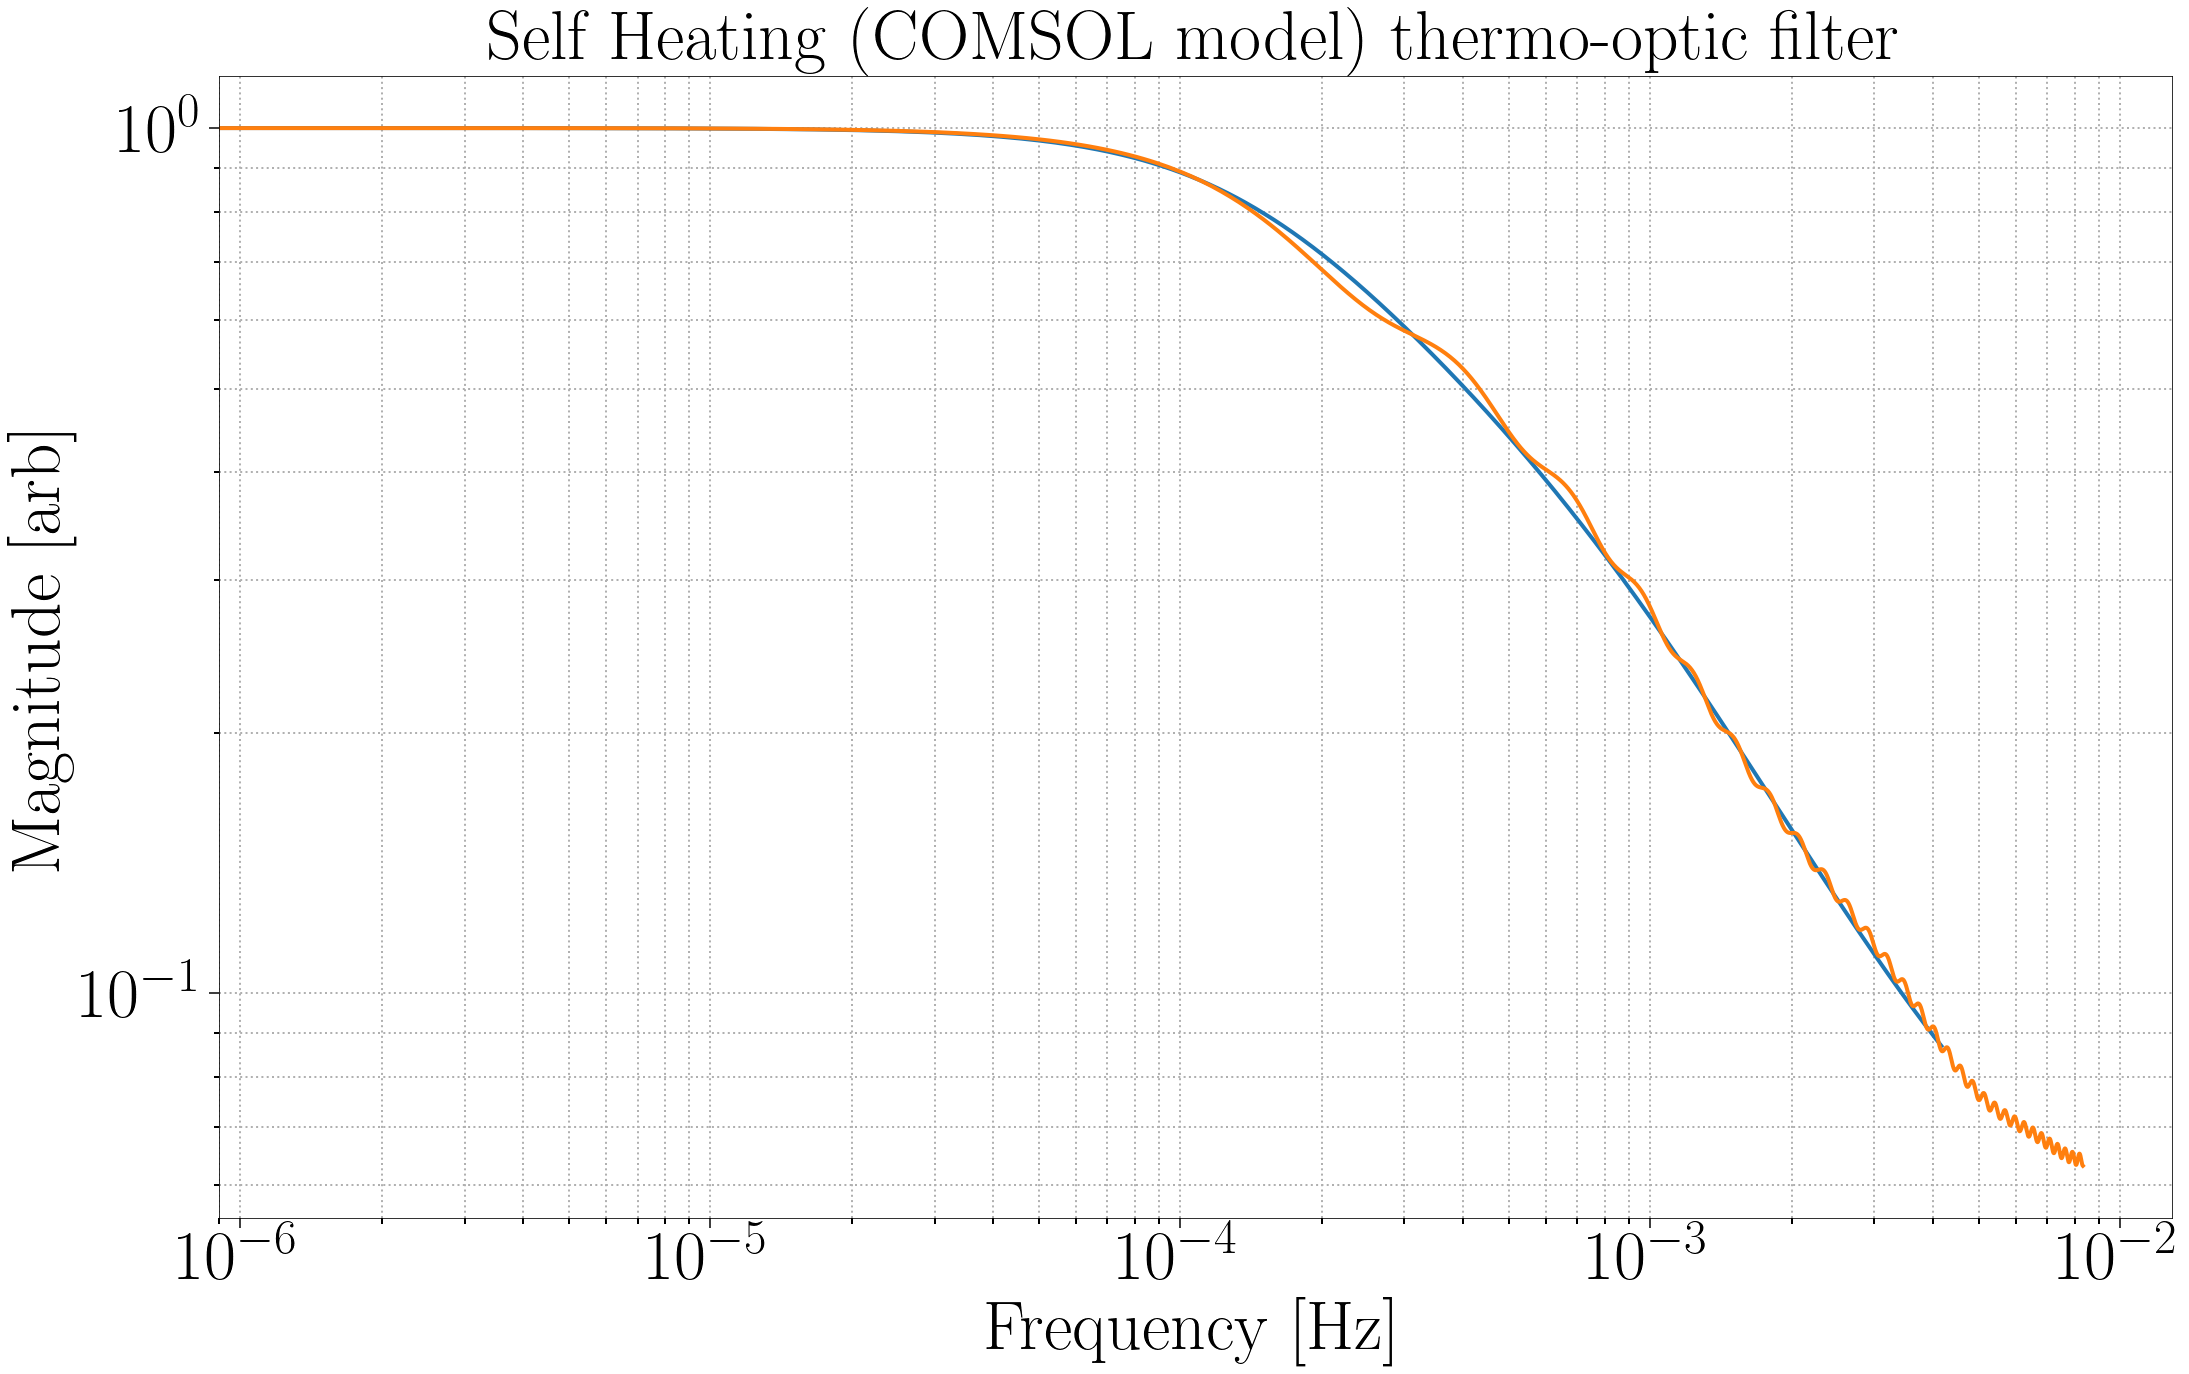

In [75]:
zeros_com = np.array([.27e-3,.7e-3,.28e-3,6.5e-3])
fit_zeros_com = -2.0*np.pi*zeros_com
poles_com = np.array([.18e-3,.225e-3,.485e-3,.83e-3])
fit_poles_com = -2.0*np.pi*poles_com

k_com =.985 #This gain is not initally correct

zpk_com = signal.ZerosPolesGain(fit_zeros_com, fit_poles_com, k_com)
F_com, H_com = signal.freqresp(zpk_com, F_ir*(Fs_com/2.0))
k_new_com = abs(H_ir[0])/abs(H_ir[0]*H_com[0])

fig6 = plt.figure()
plt.loglog(F_com/(2*np.pi), abs(H_com)*k_new_com, label='Fitted zpk Filter',linewidth=4)
plt.loglog(F_ir*Fs_com/(2*np.pi), abs(H_ir)/abs(H_ir[0]), label='Plant filter',linewidth=4)
plt.ylabel('Magnitude [arb]')
plt.xlabel('Frequency [Hz]')
plt.title('Self Heating (COMSOL model) thermo-optic filter')
plt.savefig('../figs/TCS/self_heating_zpk.pdf', dpi=300, bbox_inches='tight')

In [76]:
G_3 = signal.ZerosPolesGain(fit_zeros_com, fit_poles_com, k_new_com)
trhy1 = np.arange(0, trhy[-1]*2,60)
unit_step_testing1 = np.zeros(np.shape(trhy1))
unit_step_testing1[trhy1>0] = 1
[ _ ,y_self_test_longer, _] = signal.lsim(G_3, unit_step_testing1, trhy1)

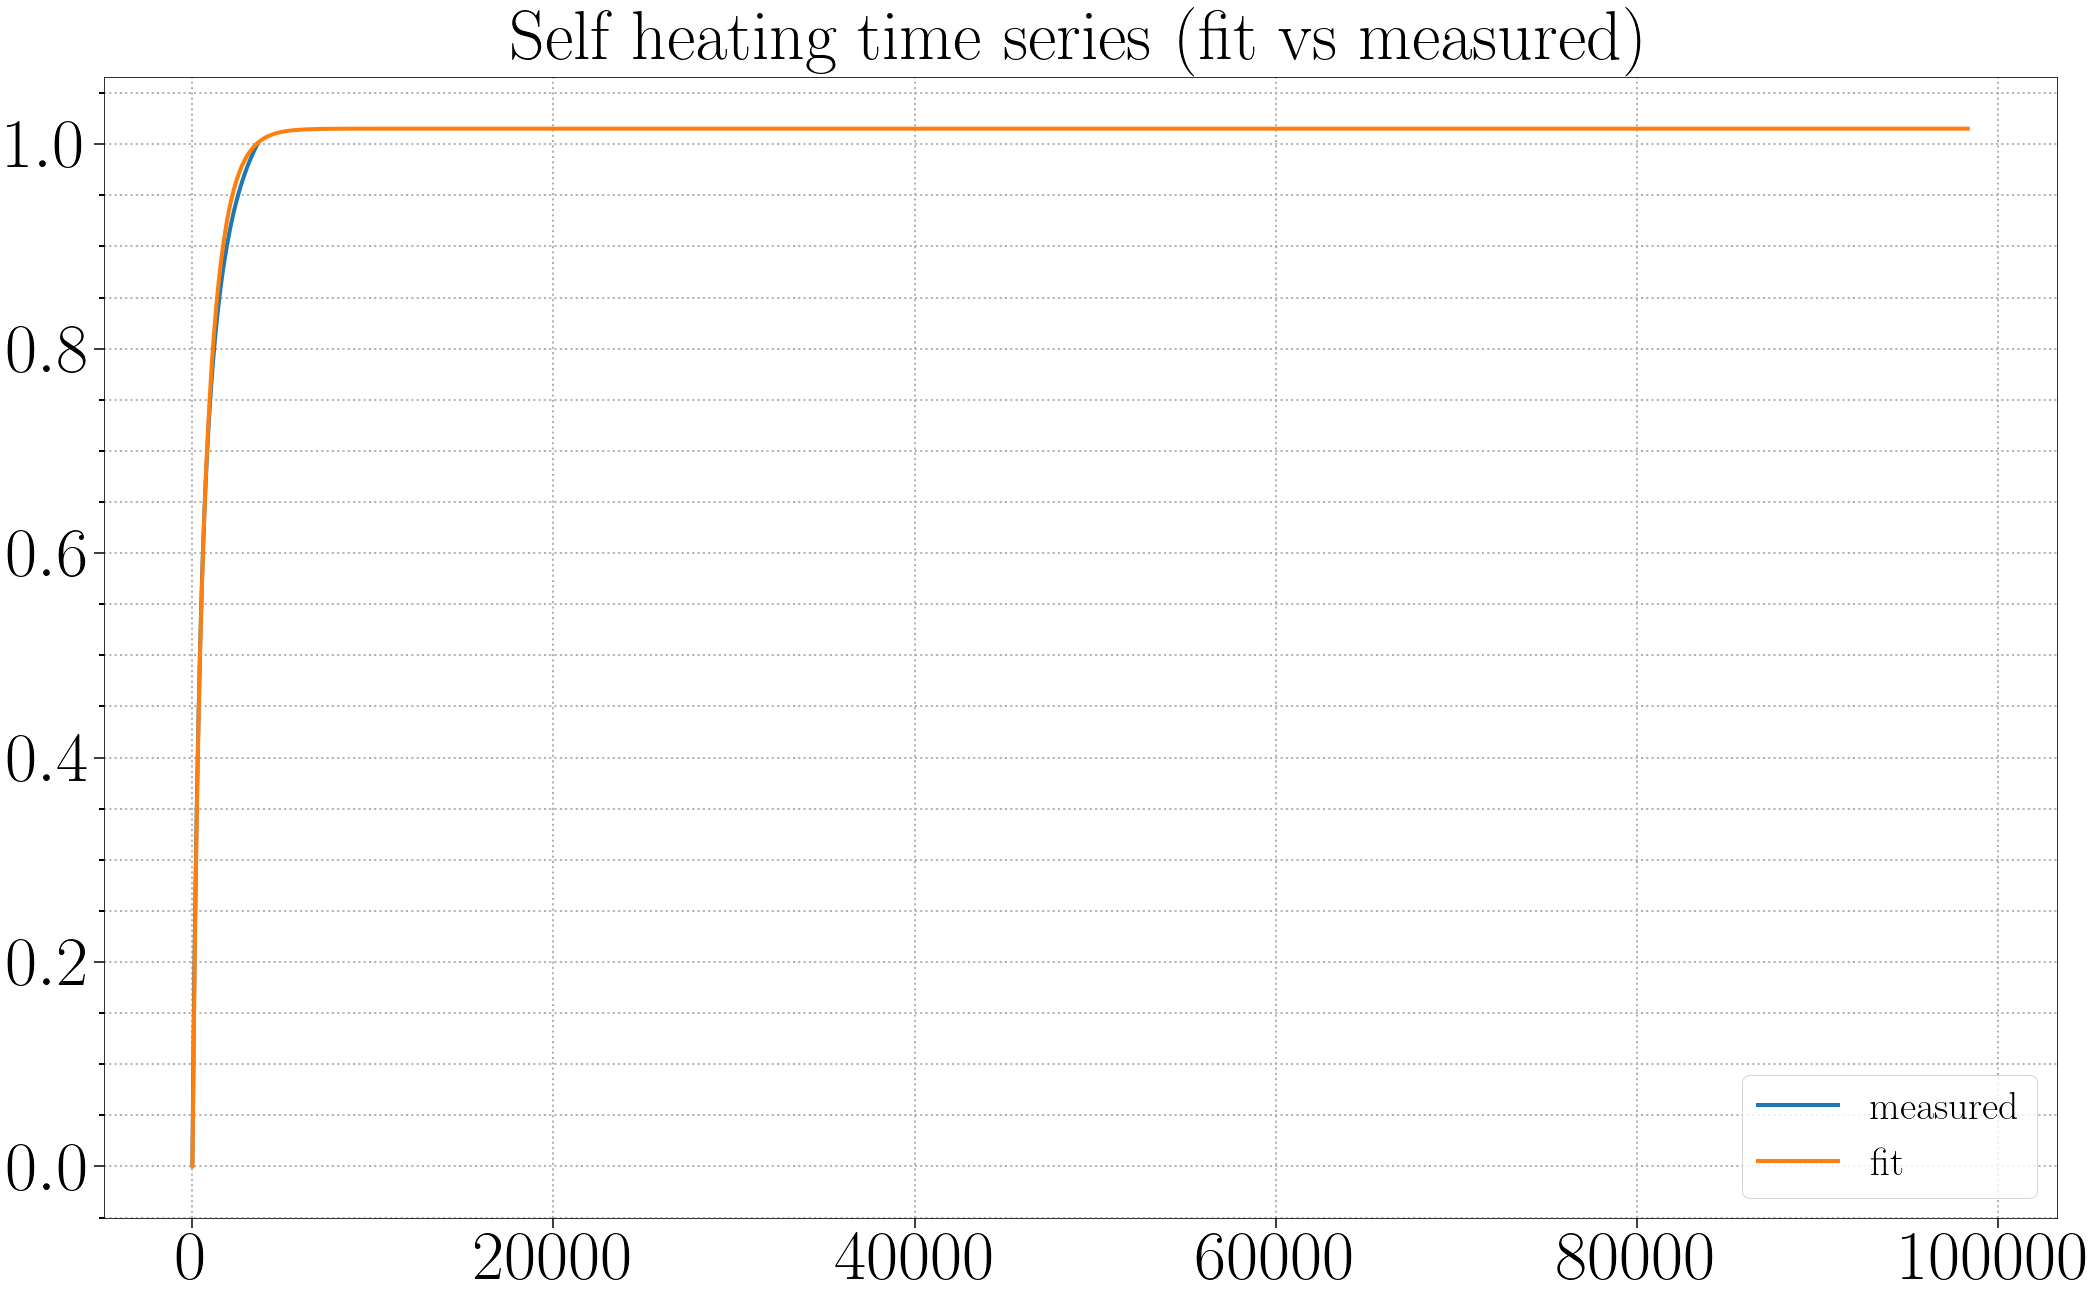

In [77]:
plt.plot(t_com,defocus,label='measured',linewidth=4)
plt.plot(trhy1,y_self_test_longer,label='fit',linewidth=4)
plt.title('Self heating time series (fit vs measured)')
plt.legend()

In [78]:
t_co2 = np.arange(0,len(co2y[:,0]),1)*60
defocus_co2 = (co2y_smooth + abs(min(co2y_smooth)))/P_CO2Y
ir_co2  = (defocus_co2[1:] - defocus_co2[:-1])
t_ir_co2 = t_co2[:((len(t_co2)-1))]

In [79]:
[F_ir_co2,H_ir_co2]=signal.freqz(ir_co2, 1, worN=3000,whole=False) 
Fs_co2 =1/(t_co2[1]-t_co2[0])

In [80]:
z1 = .165e-3
z2 = .38e-3
z3 = .43e-3
zeros_co2 = np.array([z1,z2, z3])
fit_zeros_co2 = -2.0*np.pi*zeros_co2
p1 = .135e-3
p2 = .135e-3
p3 = .175e-3
p4 = .24e-3
poles_co2 = np.array([p1, p2, p3, p4])
fit_poles_co2 = -2.0*np.pi*poles_co2

k_co2 = 1 #This gain is not initally correct

zpk_co2 = signal.ZerosPolesGain(fit_zeros_co2, fit_poles_co2, k_co2)
F_co2, H_co2 = signal.freqresp(zpk_co2, F_ir_co2*(Fs_co2/2.0))

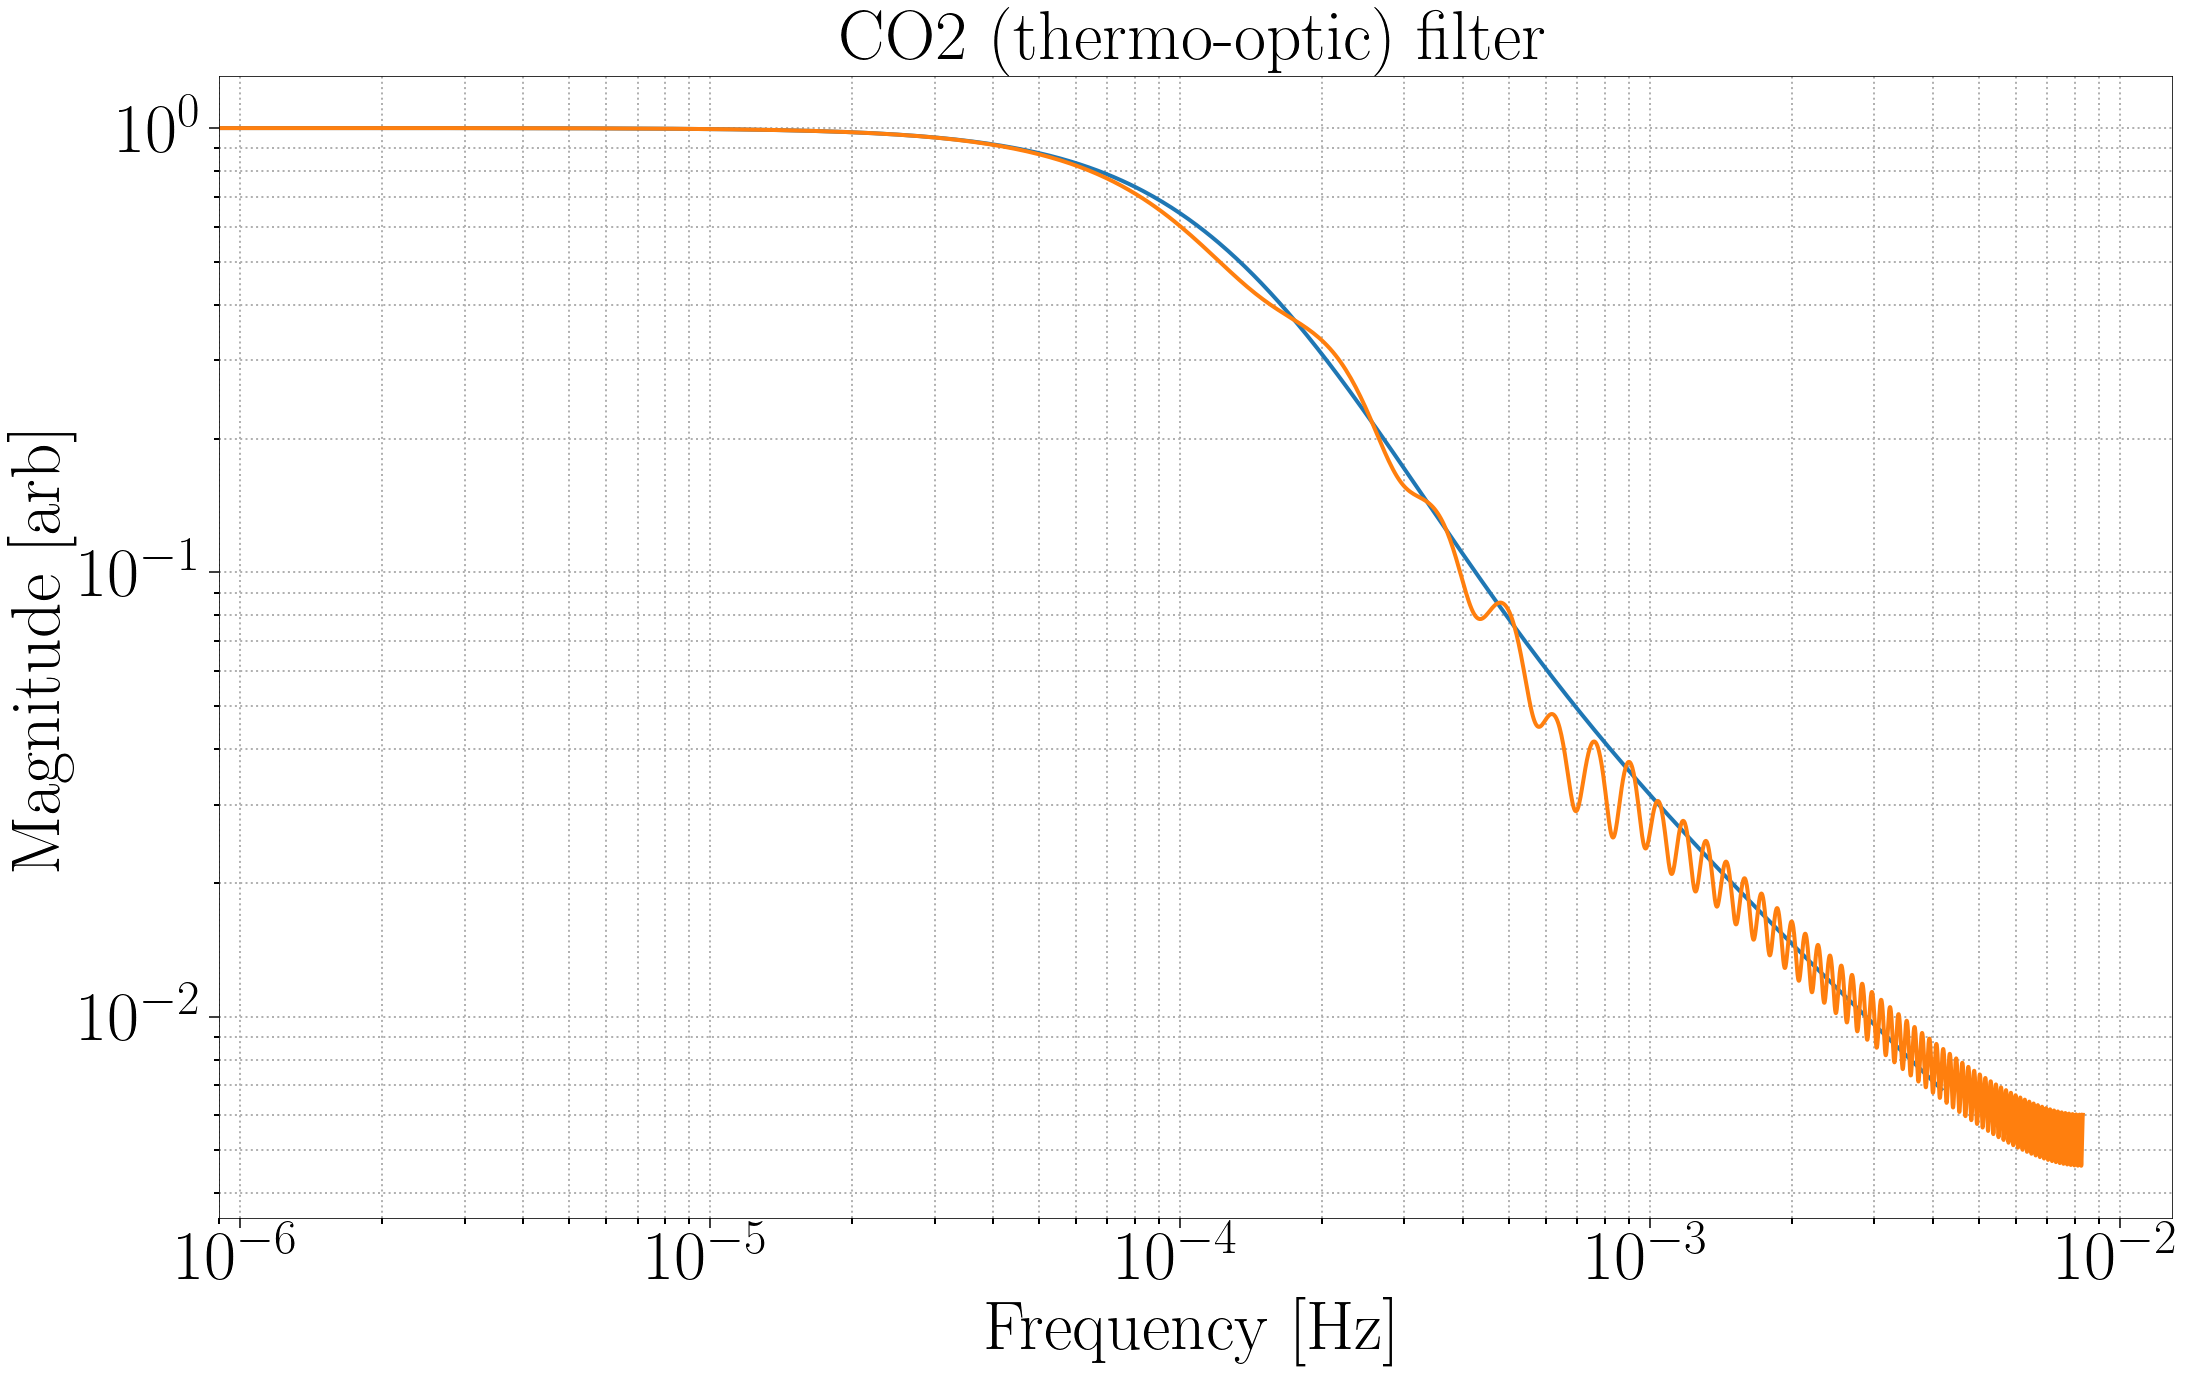

In [81]:
plt.loglog(F_co2/(2*np.pi), abs(H_co2)/abs(H_co2)[0], label='Fitted zpk Filter',linewidth=4)
plt.loglog(F_ir_co2*Fs_co2/(2*np.pi), abs(H_ir_co2)/abs(H_ir_co2)[0], label='Plant filter',linewidth=4)
plt.ylabel('Magnitude [arb]')
plt.xlabel('Frequency [Hz]')
plt.title('CO2 (thermo-optic) filter')
plt.savefig('../figs/TCS/CO2_zpk.pdf', dpi=300, bbox_inches='tight')

In [82]:
k_new_co2 = 1/abs(H_co2)[0]

In [83]:
G_4 = signal.ZerosPolesGain(fit_zeros_co2, fit_poles_co2, k_new_co2)
[ _ ,y_co2_test_longer, _] = signal.lsim(G_4, unit_step_testing1, trhy1)

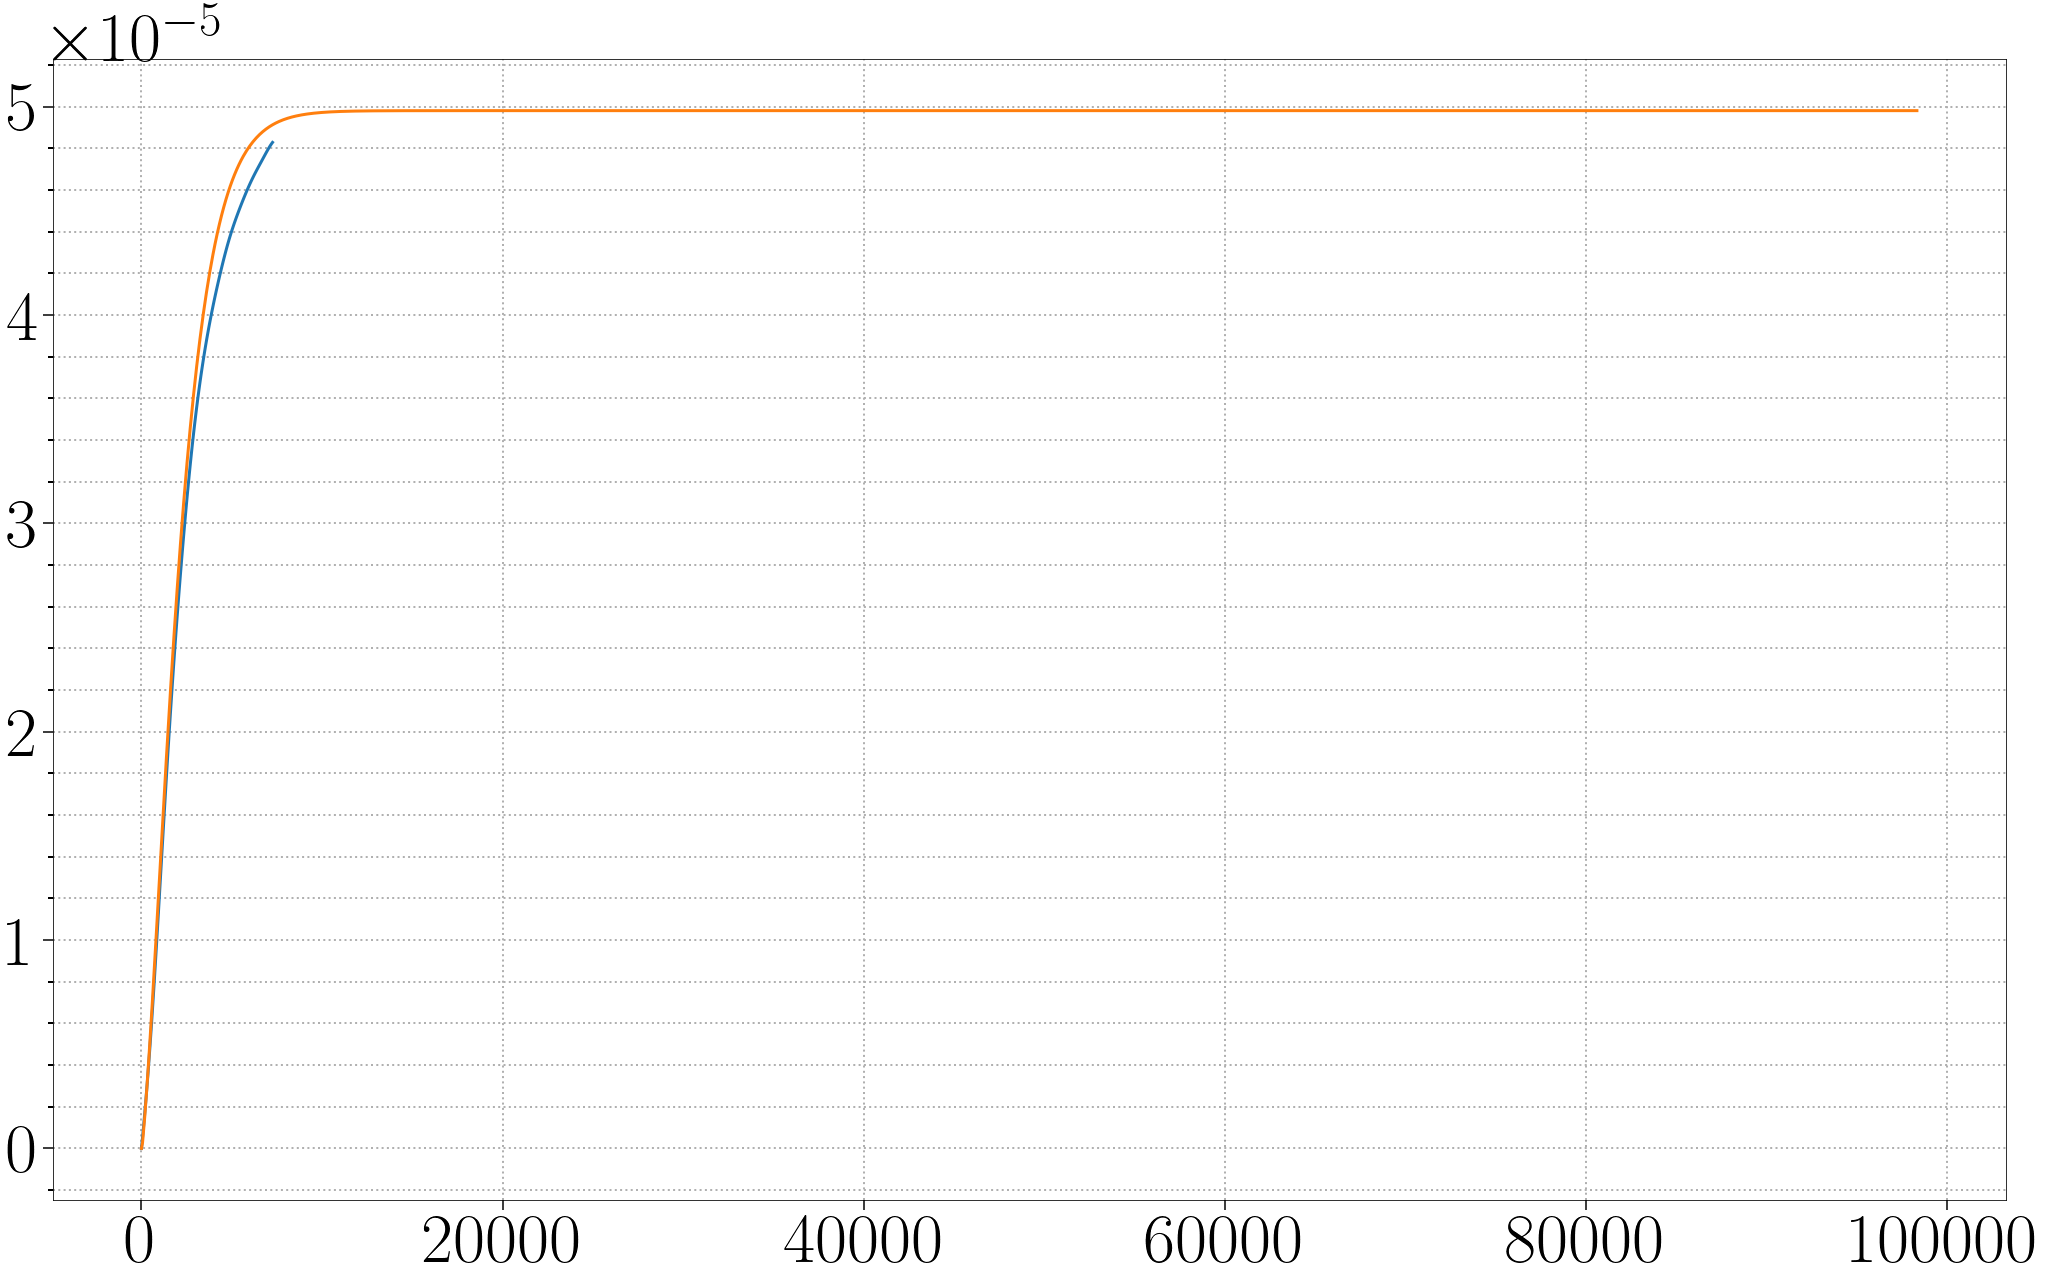

In [84]:
plt.plot(t,co2y_smooth + abs(min(co2y_smooth)), label='CO2Y laser (.95 W)')
plt.plot(trhy1, y_co2_test_longer*max(defocus_co2)*.98, label ='CO2Y laser (.95W) (filter)')

In [128]:
shorten_div = 1.45

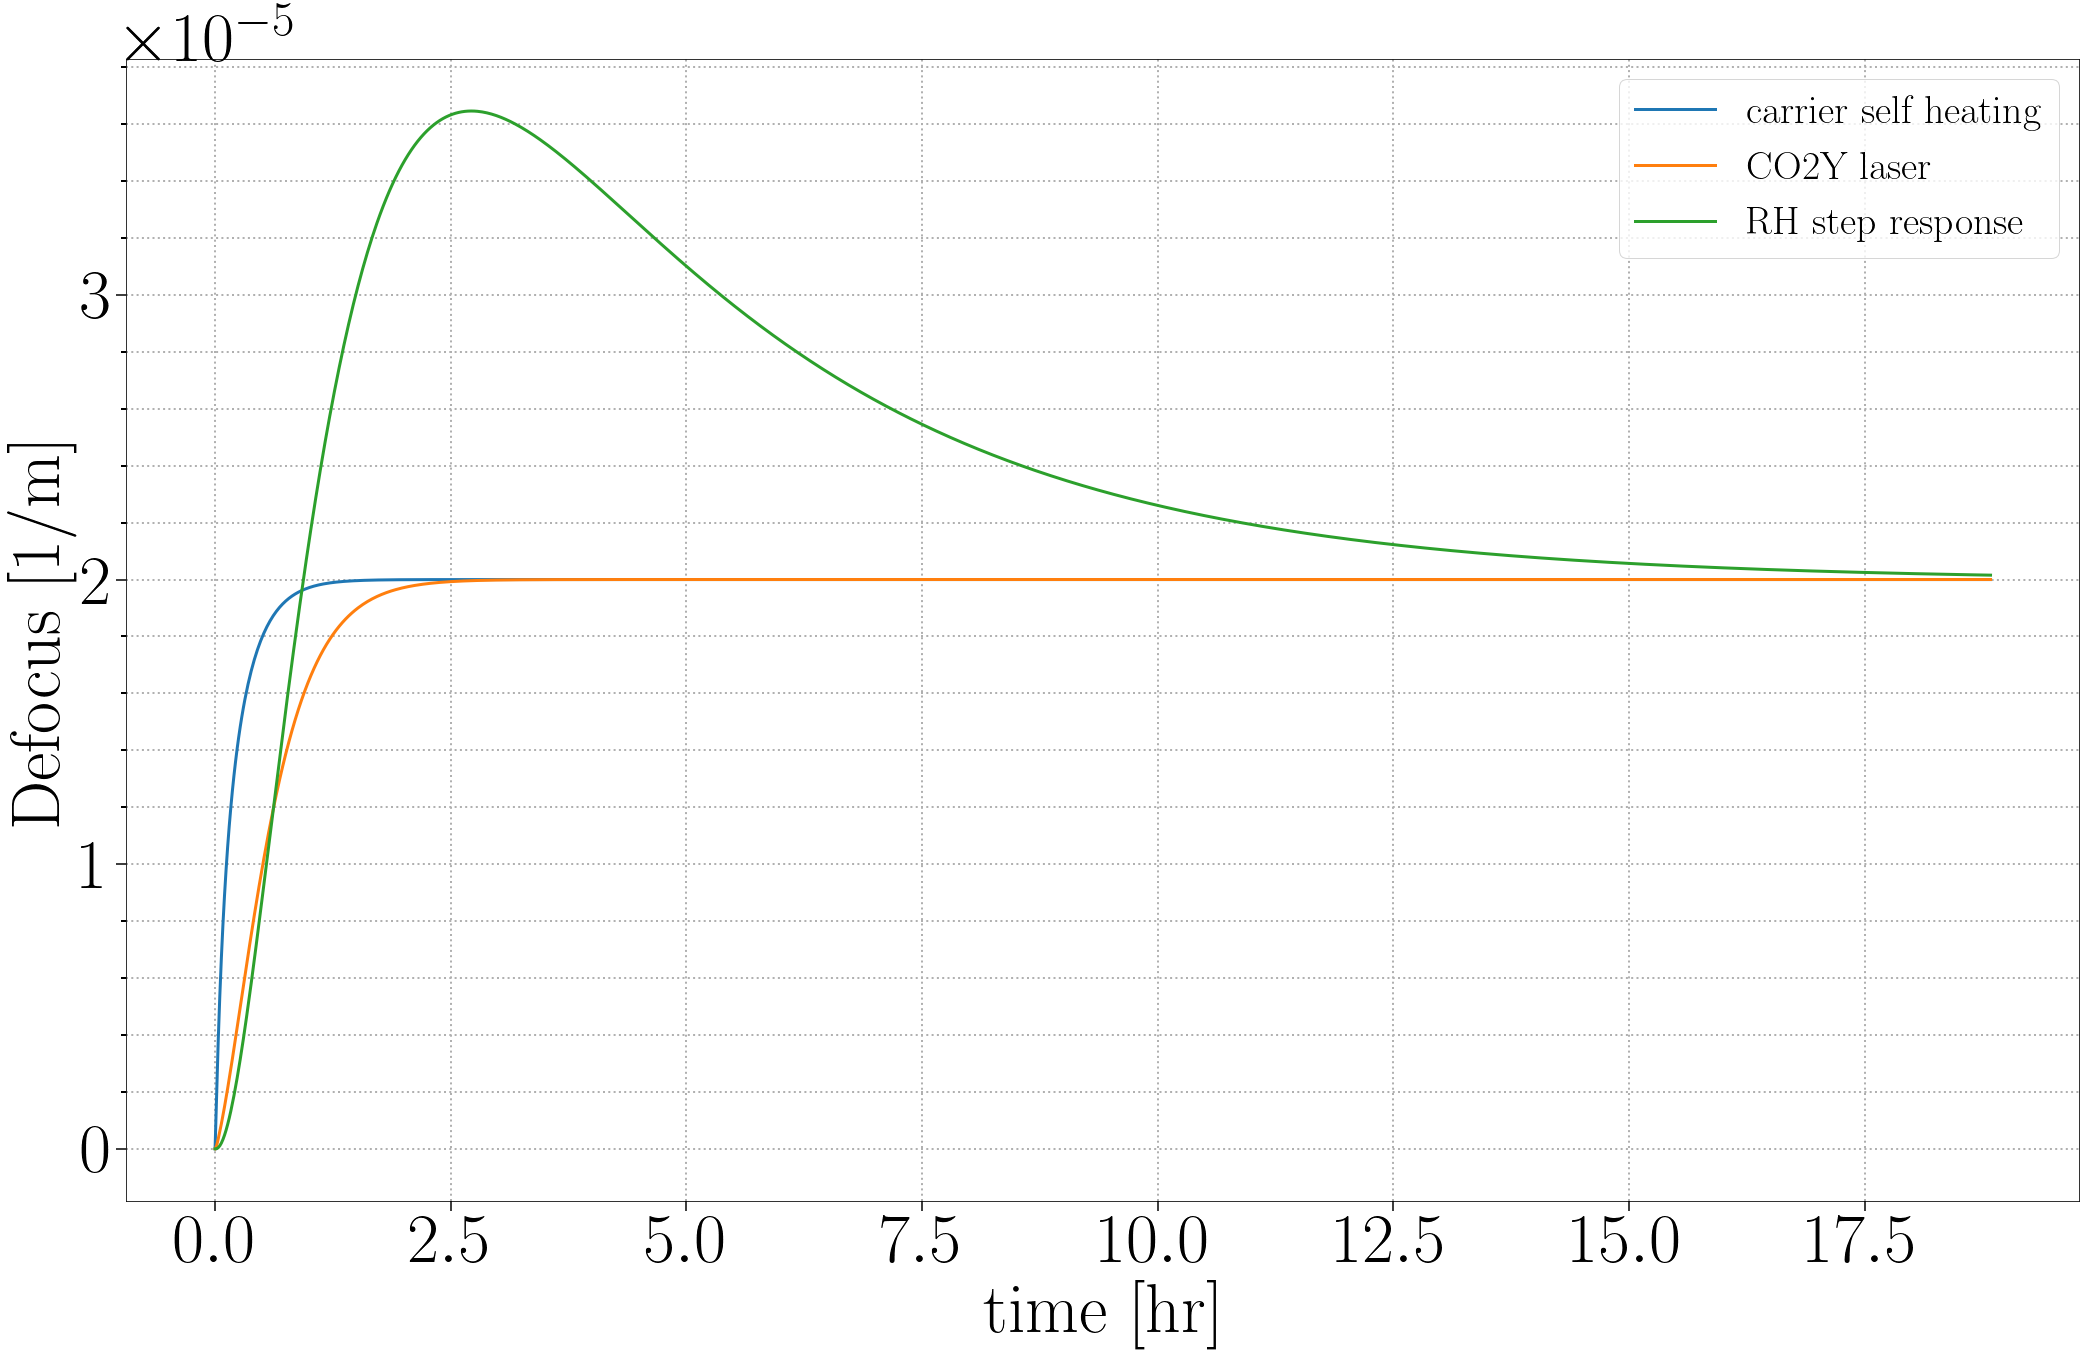

In [129]:
plt.plot(trhy1[0:int(len(trhy1)/shorten_div)]/3600, y_self_test_longer[0:int(len(trhy1)/shorten_div)]*.98*(2.01*1e-5) , label='carrier self heating')
#plt.plot(t_rhy1,y_self_test_longer*.62e-4,label='fit',linewidth=4)

plt.plot(trhy1[0:int(len(trhy1)/shorten_div)]/3600, y_co2_test_longer[0:int(len(trhy1)/shorten_div)]*(2.0*1e-5) , label='CO2Y laser')

plt.plot(trhy1[0:int(len(trhy1)/shorten_div)]/3600, y_RH_test[0:int(len(trhy1)/shorten_div)], label='RH step response')
#plt.plot(rhy[:,0], rhy[:,1])

plt.legend()
plt.xlabel('time [hr]')
plt.ylabel('Defocus [1/m]')
plt.savefig('../figs/TCS/TCS_resp_sim.pdf', dpi=300, bbox_inches='tight')